# Analytics Vidhya Job-a-thon September

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from pandas import Series

# To check for normal distribution 
from scipy import stats
from scipy.stats import norm
from scipy.stats import probplot

# For Feature Importance
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) Sales
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# For Machine Learning Models
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# For Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

## Importing the datasets

In [2]:
train_original = pd.read_csv('TRAIN.csv',parse_dates= ['Date'])
test_original = pd.read_csv('TEST_FINAL.csv',parse_dates= ['Date'])

# Making a copy of the datasets
train = train_original.copy()
test = test_original.copy()

## Data Exploration

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 14.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             22265 non-null  object        
 1   Store_id       22265 non-null  int64         
 2   Store_Type     22265 non-null  object        
 3   Location_Type  22265 non-null  object        
 4   Region_Code    22265 non-null  object        
 5   Date           22265 non-null  datetime64[ns]
 6   Holiday        22265 non-null  int64         
 7   Discount       22265 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.4+ MB


In [5]:
train.describe(include='all')

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
count,188340,188340.000000,188340,188340,188340,188340,188340.000000,188340,188340.000000,188340.000000
unique,188340,NaN,4,5,4,516,NaN,2,NaN,NaN
top,T1000001,NaN,S1,L1,R1,2018-01-01 00:00:00,NaN,No,NaN,NaN
freq,1,NaN,88752,85140,63984,365,NaN,104051,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2019-05-31 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,183.000000,NaN,NaN,NaN,NaN,0.131783,NaN,68.205692,42784.327982
std,NaN,105.366308,NaN,NaN,NaN,NaN,0.338256,NaN,30.467415,18456.708302
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000
25%,NaN,92.000000,NaN,NaN,NaN,NaN,0.000000,NaN,48.000000,30426.000000


## Parsing Date and Extracting Features

In [6]:
# Extracting the year, month, day
for i in (train,test):
    i['Year'] = i.Date.dt.year
    i['Month'] = i.Date.dt.month
    i['Day'] = i.Date.dt.day
    i['Day_of_Week'] = i['Date'].dt.dayofweek

In [7]:
# Creating a function to assign 1 if the day of the week is a weekend and 0 otherwise
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

train['Weekend'] = train['Date'].apply(weekend)
test['Weekend'] = test['Date'].apply(weekend)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
 10  Year           188340 non-null  int64         
 11  Month          188340 non-null  int64         
 12  Day            188340 non-null  int64         
 13  Day_of_Week    188340 non-null  int64         
 14  Weekend        188340 non-null  int64         
dtype

## Exploratory Data Analysis

### Distribution of Sales across Store_id, Store_Type, Location_Type, Region_Code

In [9]:
Order_Sales_Analysis = train.copy()
Order_Sales_Analysis['SalePerOrder'] = Order_Sales_Analysis['Sales']/Order_Sales_Analysis['#Order']

In [10]:
# Distribution of sales and orders across stores
Order_Sales_Analysis = train.copy()
Order_Sales_Analysis['SalePerOrder'] = Order_Sales_Analysis['Sales']/Order_Sales_Analysis['#Order']

Order_Sales_Analysis.groupby('Store_id')['#Order', 'Sales', 'SalePerOrder'].sum().sort_values('Sales', ascending=False)

,#Order,Sales,SalePerOrder
Store_id,,,
175,94381,52560255.15,285557.156295
337,87707,49342417.92,288548.434389
126,71550,46351830.51,332704.318571
312,82153,44890318.23,281417.138228
146,79851,43697690.67,280874.002479
...,...,...,...
289,18888,11653520.91,317517.231863
77,16330,11081527.92,348505.093810
71,17137,10911699.99,326819.414811


Store with Store_id 175 has the highest number of sales and orders. Some stores are observed to have high sale per order although the number of orders are comparetively lower. 

In [11]:
#Distribution of sales and orders across stores types
Order_Sales_Analysis = train.copy()
Order_Sales_Analysis['SalePerOrder'] = Order_Sales_Analysis['Sales']/Order_Sales_Analysis['#Order']

Order_Sales_Analysis.groupby('Store_Type')['#Order', 'Sales', 'SalePerOrder'].sum().sort_values('Sales', ascending=False)

,#Order,Sales,SalePerOrder
Store_Type,,,
S1,5149577,3.343866e+09,5.742099e+07
S4,4702286,2.752946e+09,2.693961e+07
S3,1824495,1.165658e+09,1.572429e+07
S2,1169502,7.955308e+08,1.956583e+07


Store Type S1 is leading in Sales.

In [12]:
#Distribution of sales and orders across location types
Order_Sales_Analysis = train.copy()
Order_Sales_Analysis['SalePerOrder'] = Order_Sales_Analysis['Sales']/Order_Sales_Analysis['#Order']

Order_Sales_Analysis.groupby('Location_Type')['#Order', 'Sales', 'SalePerOrder'].sum().sort_values('Sales', ascending=False)

,#Order,Sales,SalePerOrder
Location_Type,,,
L1,5556742,3.529359e+09,5.476345e+07
L2,4600675,2.872964e+09,3.085196e+07
L3,1590881,9.897865e+08,1.884513e+07
L5,584087,3.509163e+08,8.483379e+06
L4,513475,3.149745e+08,6.706797e+06


Majority of sales is observed in L1 location type. L4 and L5 location types perform poorly. The sales in these locations is ten times less than that of L1. 

In [13]:
#Distribution of sales and customers across regions
Order_Sales_Analysis = train.copy()
Order_Sales_Analysis['SalePerOrder'] = Order_Sales_Analysis['Sales']/Order_Sales_Analysis['#Order']

Order_Sales_Analysis.groupby('Region_Code')['#Order', 'Sales', 'SalePerOrder'].sum().sort_values('Sales', ascending=False)

,#Order,Sales,SalePerOrder
Region_Code,,,
R1,5094794,2.992243e+09,3.799990e+07
R2,3402429,2.170172e+09,3.472698e+07
R3,2834847,1.870205e+09,2.937110e+07
R4,1513790,1.025381e+09,1.755274e+07


### Sales Trends

Stores in Region Code R1 record the highest sales across the four region codes.

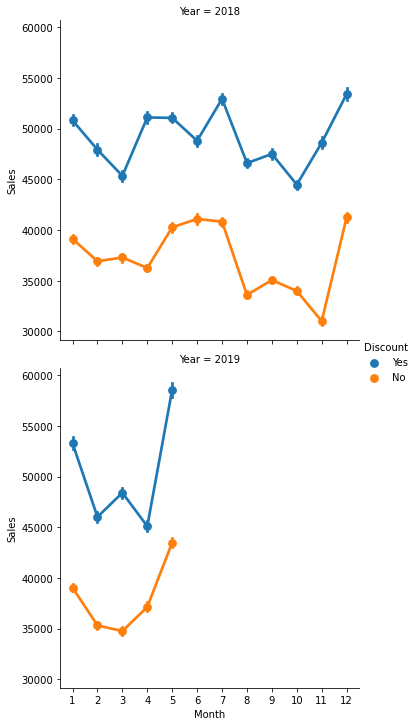

In [14]:
# Sales trend over the months
sns.factorplot(data = train, x ="Month", y = "Sales", 
               hue = 'Discount',
               row = "Year"
             );

    The graph clearly shows that there is a significant impact by discount on sales. The sales during the time period when discount is offered is approx. 10000 more than when the normal sales.

    The sales increases during April, May, July and December, showing seasonality. 

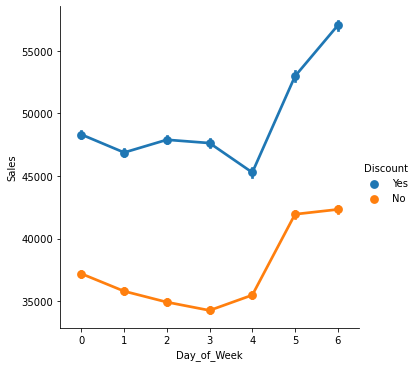

In [15]:
# Sales trend over days
sns.factorplot(data = train, x = "Day_of_Week", y = "Sales", hue = "Discount");

Sales is higher during the weekend. 

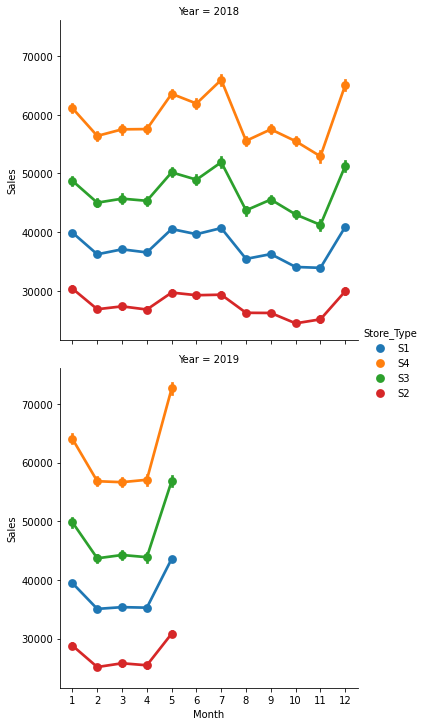

In [16]:
# Sales trend across Store Types
sns.factorplot(data = train, x ="Month", y = "Sales", 
               hue = 'Store_Type',
               row = "Year"
             );

Stores of Store Type S4 record higher sales compared to the other three store types

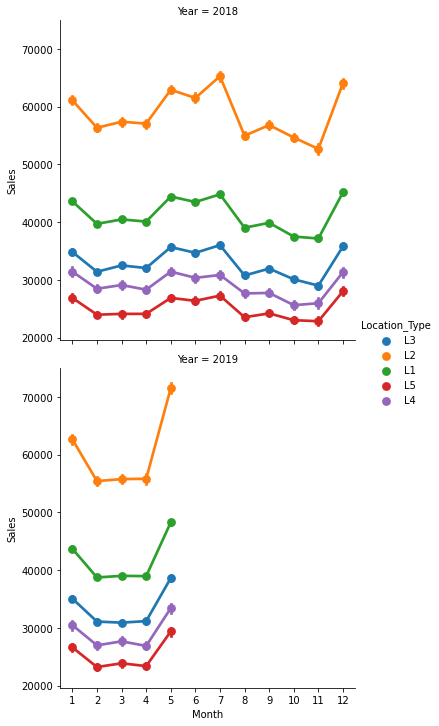

In [17]:
# Sales trend across Location Types
sns.factorplot(data = train, x ="Month", y = "Sales", 
               hue = 'Location_Type',
               row = "Year"
             );

Highest sales are observed in stores that are in Location Type L2.

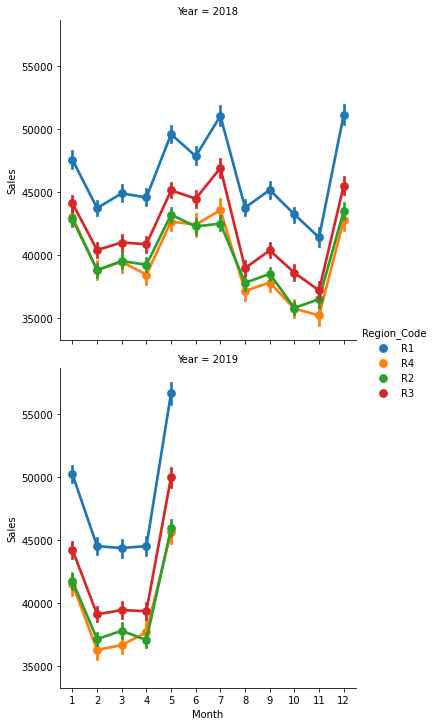

In [18]:
# Sales trend across Region Codes
sns.factorplot(data = train, x ="Month", y = "Sales", 
               hue = 'Region_Code',
               row = "Year"
             );

Stores in Region Code R1 lead among the Region Codes in terms of sales.

## Data Preprocessing & Feature Engineering

### Feature Generation

In [19]:
## The time period between 25th and 5th of the month is when people receive their salaries. Therefore, buying will be higher in this period. 
train['Dateinbetween25and5'] = [1 if d >= 25 or d <= 5 else 0 for d in train['Day']]
test['Dateinbetween25and5'] = [1 if d >= 25 or d <= 5 else 0 for d in test['Day']]

# Generating features from Holiday variable
train['Holiday_weekend'] = [1 if (we == 1 and h == 1) else 0 for we,h in train[['Weekend','Holiday']].values]
train['Holiday_weekday'] = [1 if (we == 0 and h == 1) else 0 for we,h in train[['Weekend','Holiday']].values]

test['Holiday_weekend'] = [1 if (we == 1 and h == 1) else 0 for we,h in test[['Weekend','Holiday']].values]
test['Holiday_weekday'] = [1 if (we == 0 and h == 1) else 0 for we,h in test[['Weekend','Holiday']].values]

# Removing Holiday variable
train.drop(['Holiday'], axis = 1, inplace = True)
test.drop(['Holiday'], axis = 1, inplace = True)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   188340 non-null  object        
 1   Store_id             188340 non-null  int64         
 2   Store_Type           188340 non-null  object        
 3   Location_Type        188340 non-null  object        
 4   Region_Code          188340 non-null  object        
 5   Date                 188340 non-null  datetime64[ns]
 6   Discount             188340 non-null  object        
 7   #Order               188340 non-null  int64         
 8   Sales                188340 non-null  float64       
 9   Year                 188340 non-null  int64         
 10  Month                188340 non-null  int64         
 11  Day                  188340 non-null  int64         
 12  Day_of_Week          188340 non-null  int64         
 13  Weekend       

### Encoding Categorical Variables

In [21]:
# Encoding categorical columns with onehot encoding
train = pd.get_dummies(train,columns = ['Store_Type','Location_Type','Region_Code','Discount'], drop_first=True)
test = pd.get_dummies(test,columns = ['Store_Type','Location_Type','Region_Code','Discount'],drop_first=True)

In [22]:
# Encoding the Store_id column using target encoding
def transform_test(base_col, feat_col):
   
    #Create dictionary of feature values from train data
    di = pd.Series(train[feat_col].values, index=train[base_col].values).to_dict()
        
    return test[base_col].map(di).astype(float)

train['StoreId_encoded'] = train.groupby('Store_id')['Sales'].transform('mean')
test['StoreId_encoded'] = transform_test('Store_id', 'StoreId_encoded')


In [23]:
## Dropping columns that are not necessary.
# Order column is removed as it doesn't exist in the test dataset. It cannot be used as a feature in the models. 
train.drop(['ID','Store_id','Day','Month','Year','Day_of_Week','#Order'], inplace=True, axis = 1)
test.drop(['ID','Store_id','Day','Month','Year','Day_of_Week'], inplace=True, axis = 1)

#### Time Series Analysis

For this time series analysis, we will plot one store from each store type S1, S2, S3, S4 that will represent their respective group. 

In [24]:
pd.plotting.register_matplotlib_converters()

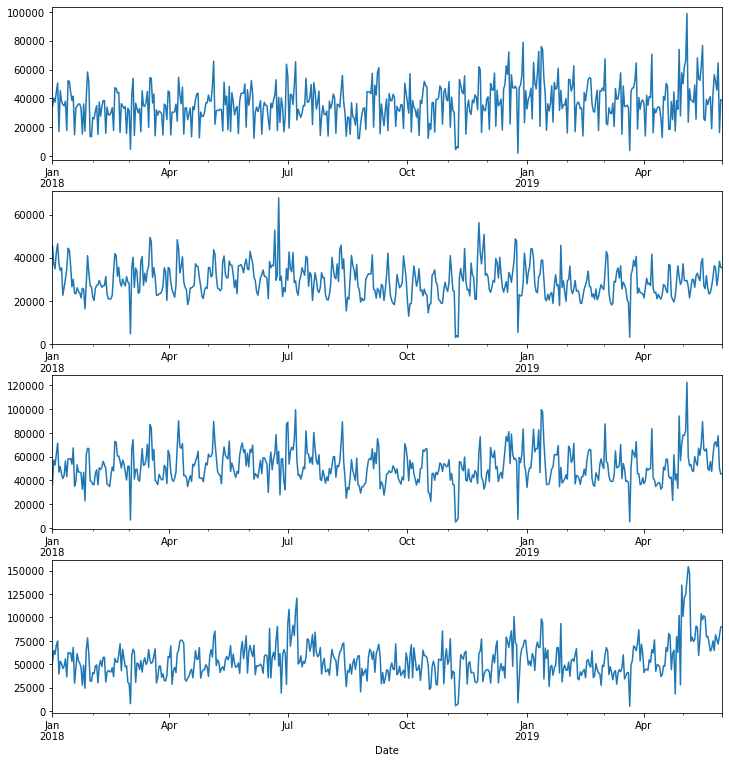

In [25]:
# Assigning one store from each category
train2 = train_original[['Date','Store_id','Sales']]
train2.set_index('Date',inplace = True)

sales_StoreS1 = train2[train2.Store_id == 249]['Sales']
sales_StoreS2 = train2[train2.Store_id == 250]['Sales']
sales_StoreS3 = train2[train2.Store_id == 252]['Sales']
sales_StoreS4 = train2[train2.Store_id == 253]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_StoreS1.plot(ax = ax1)
sales_StoreS2.plot(ax = ax2)
sales_StoreS3.plot(ax = ax3)
sales_StoreS4.plot(ax = ax4);

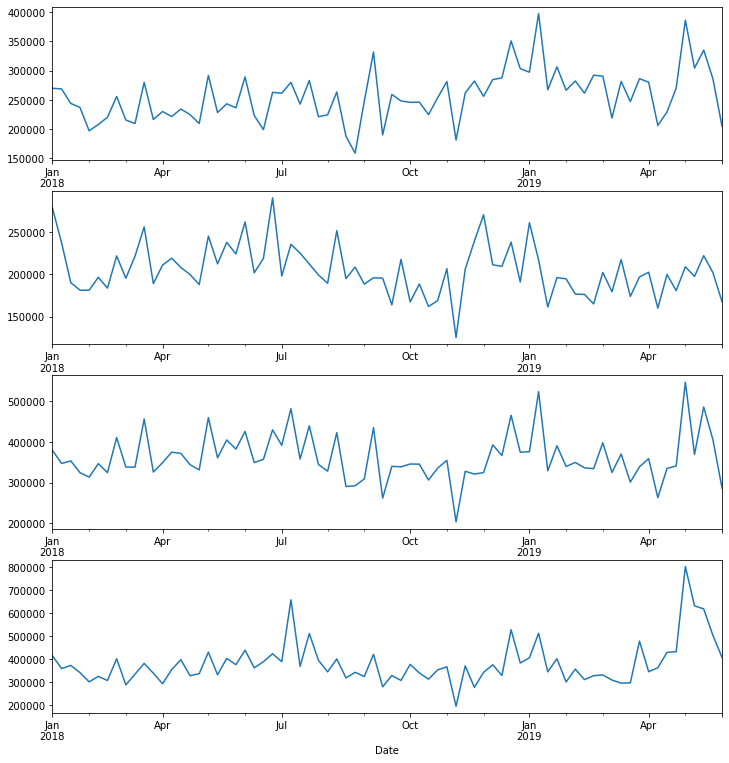

In [26]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_StoreS1.resample('W').sum().plot(ax = ax1)
sales_StoreS2.resample('W').sum().plot(ax = ax2)
sales_StoreS3.resample('W').sum().plot(ax = ax3)
sales_StoreS4.resample('W').sum().plot(ax = ax4);

#### Stationarity of Time Series

The time series data should have constant mean, constant variance and constant covariance with time to be stationary. This is a necessary prerequisite for time forecasting models.

To ensure the data is stationary, we can perform two tests to check for stationarity of the data.
1. Dicky-Fuller Test
2. Rolling Window Plots

-1. Dicky Fuller Test 
It is a statistical test that provides us with p-value and t-statistic values to test the null hypothesis that the data is not stationary. If the p-value is less than the critical value (assumed as 0.05), then it is concluded that we can reject the null hypothesis and the data is stationary. 

-2. Rolling Window Plots
These plots analyze the stability of time series models over time. The average of time series data is rolled across of a window of particular time period (e.g. 7 days) and then this is compared with the original data using plots to check if the model is stationary or not. 

In [27]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

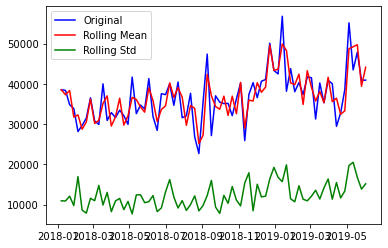

Results of Dickey-Fuller Test:
ADF Statistic: -3.779013
p-value: 0.003129
Critical Values:
1% -3.443391504492468
5% -2.8672917032172953
10% -2.5698334393109095


In [28]:
# Testing stationarity of store type a
test_stationarity(sales_StoreS1)

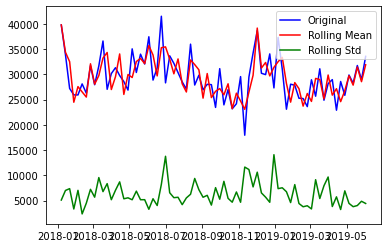

Results of Dickey-Fuller Test:
ADF Statistic: -4.625731
p-value: 0.000116
Critical Values:
1% -3.4435494520411605
5% -2.8673612117611267
10% -2.5698704830567247


In [29]:
# Testing stationarity of store type a
test_stationarity(sales_StoreS2)

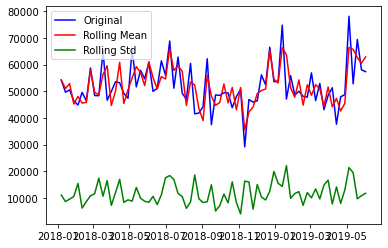

Results of Dickey-Fuller Test:
ADF Statistic: -3.793920
p-value: 0.002970
Critical Values:
1% -3.4436029548776395
5% -2.867384756137026
10% -2.5698830308597813


In [30]:
# Testing stationarity of store type a
test_stationarity(sales_StoreS3)

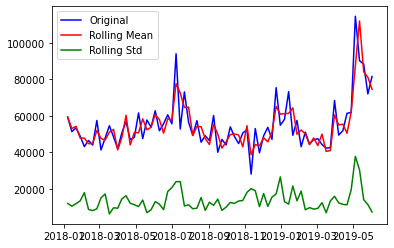

Results of Dickey-Fuller Test:
ADF Statistic: -2.748078
p-value: 0.066082
Critical Values:
1% -3.443496379464
5% -2.8673378563200003
10% -2.569858036


In [31]:
# Testing stationarity of store type a
test_stationarity(sales_StoreS4)

##### Results
-1. Dickey Fuller Test
The p-values for the all the four stores is less 0.05 and the critical values. This proves that the null hypothesis can be rejected. Therefore, the time series data is stationary.

-2. Rolling Window Plots
The above four plots for each store indicate that mean, variance and covariance of Sales remains constant over time. It is confirmed that data is stationary. 

Hence, no further transformation is required. 

#### Trend and Seasonality of Time Series

In [32]:
# Plotting seasonality and trend
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive')

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[0].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[0].legend(loc='upper left');
    
    axes[1].plot(estimated_trend, label='Trend')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual,'orange', label='Residuals')
    axes[2].legend(loc='upper left');

    plt.title('Decomposition Plots')

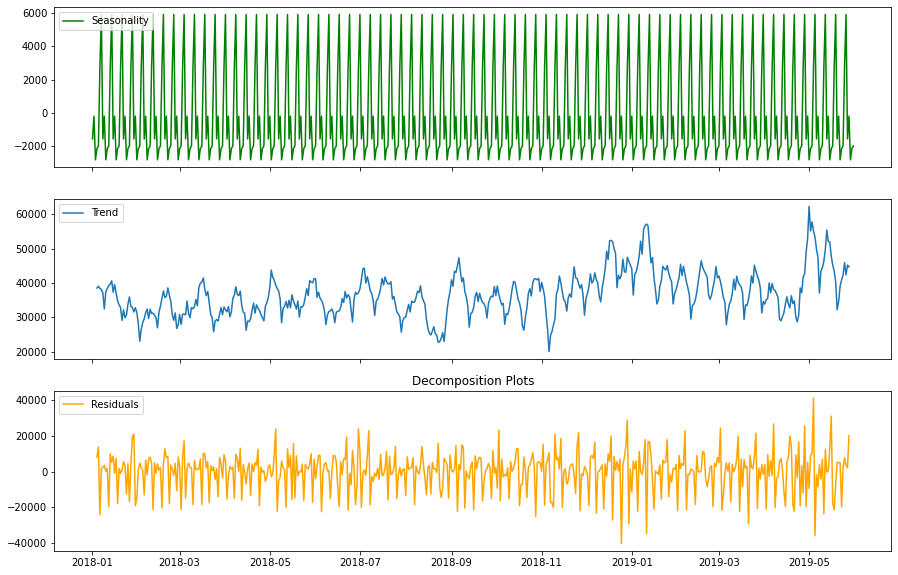

In [33]:
# Plotting seasonality and trend for store type S1
plot_timeseries(sales_StoreS1,'Store S1')

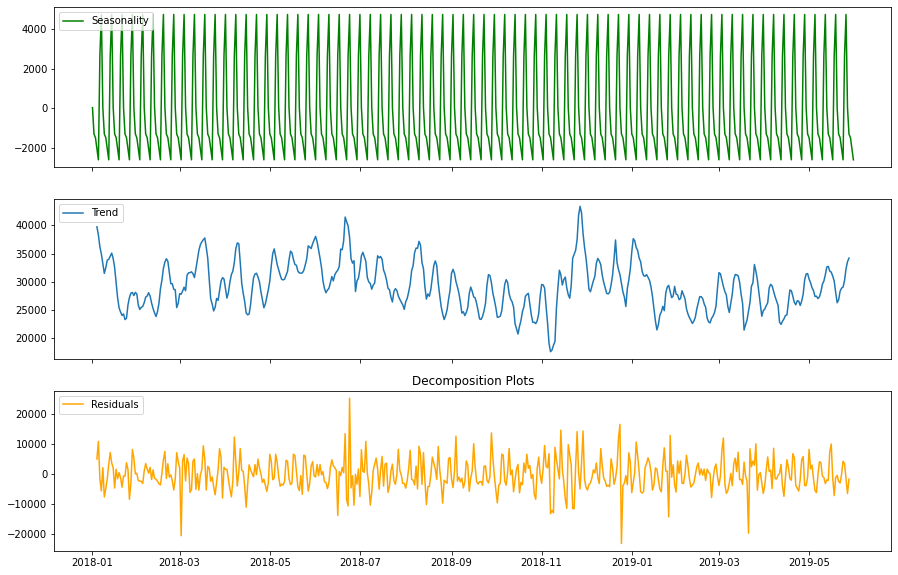

In [34]:
#Plotting seasonality and trend for store type S2
plot_timeseries(sales_StoreS2,'Store S2')

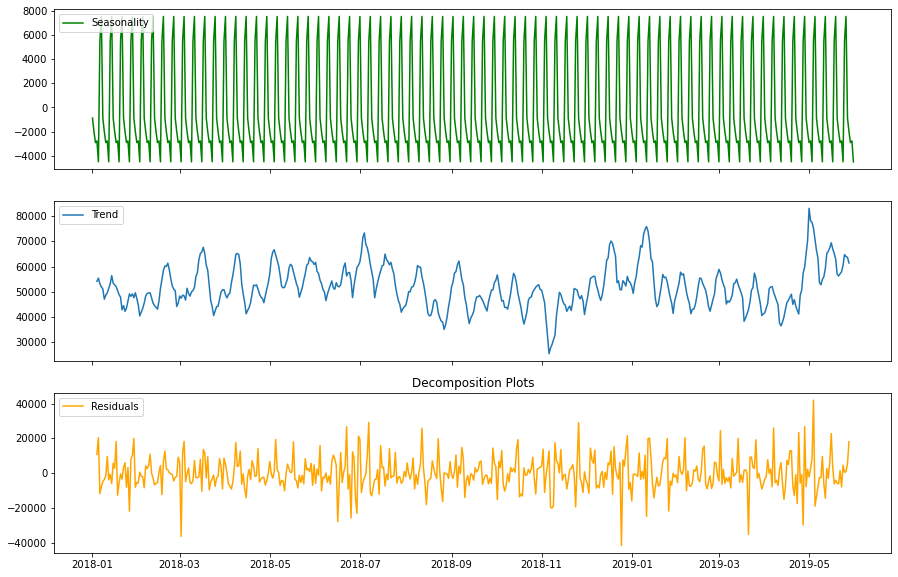

In [35]:
#Plotting seasonality and trend for store type S3
plot_timeseries(sales_StoreS3,'Store S3')

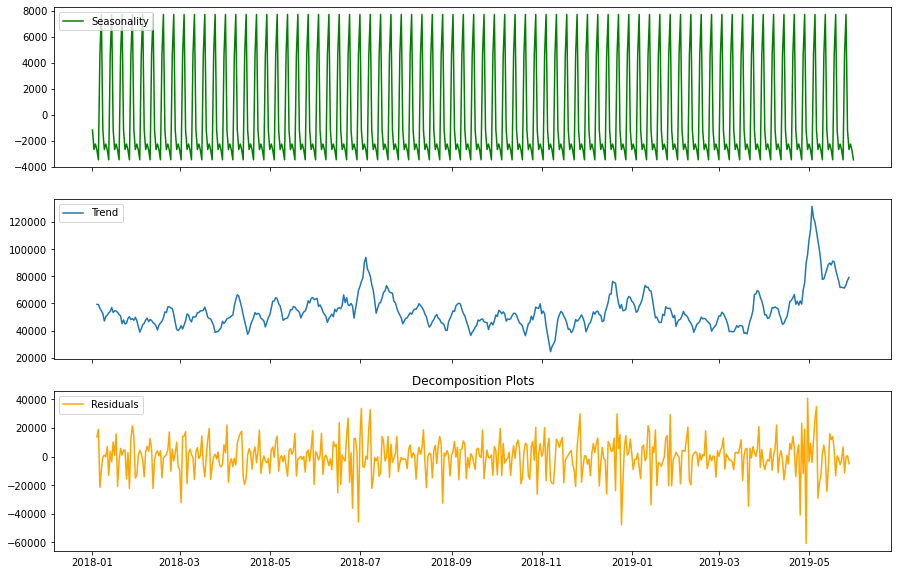

In [36]:
#Plotting seasonality and trend for store type S4
plot_timeseries(sales_StoreS4,'Store S4')

It is observed from these plots that the time series data has weekly seasonality and cyclic trends. 

## Sales Prediction using Machine Learning

### Further Feature Engineering for Prediction with Machine Learning

In [37]:
## Removing rows with no sales
train = train[train['Sales'] > 0]

In [38]:
# Removing Date as it is not required after extracting variables from it. 
train.drop(['Date'], inplace=True, axis = 1)
test.drop(['Date'], inplace=True, axis = 1)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188321 entries, 0 to 188339
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Sales                188321 non-null  float64
 1   Weekend              188321 non-null  int64  
 2   Dateinbetween25and5  188321 non-null  int64  
 3   Holiday_weekend      188321 non-null  int64  
 4   Holiday_weekday      188321 non-null  int64  
 5   Store_Type_S2        188321 non-null  uint8  
 6   Store_Type_S3        188321 non-null  uint8  
 7   Store_Type_S4        188321 non-null  uint8  
 8   Location_Type_L2     188321 non-null  uint8  
 9   Location_Type_L3     188321 non-null  uint8  
 10  Location_Type_L4     188321 non-null  uint8  
 11  Location_Type_L5     188321 non-null  uint8  
 12  Region_Code_R2       188321 non-null  uint8  
 13  Region_Code_R3       188321 non-null  uint8  
 14  Region_Code_R4       188321 non-null  uint8  
 15  Discount_Yes     

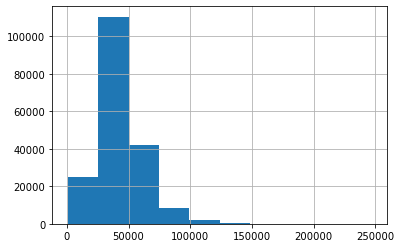

In [40]:
### Examining the target variable
train['Sales'].hist()
plt.show()

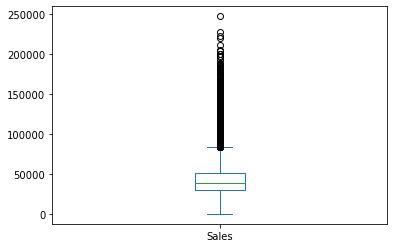

In [41]:
train['Sales'].plot(kind='box')
plt.show()


 mu = 42788.64 and sigma = 18452.59



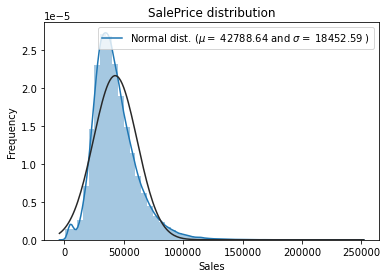

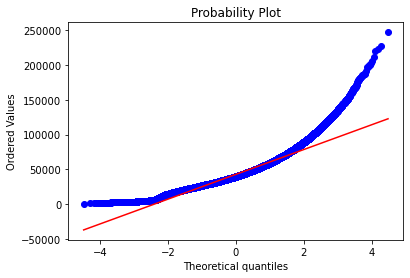

In [42]:
## Checking the distribution of the target variable
sns.distplot(train['Sales'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Sales'], plot=plt)
plt.show()

The target variable is slightly negatively skewed. It has to be transformed to ensure normal distribution. 

#### Checking the right mode of transformation 

<AxesSubplot:xlabel='Sales', ylabel='Density'>

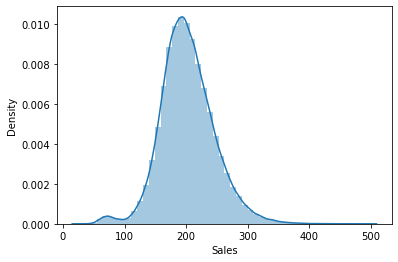

In [43]:
# Square Root Transformation
sqrt_sp = train['Sales']**(.5)
sns.distplot(sqrt_sp)


<AxesSubplot:xlabel='Sales', ylabel='Density'>

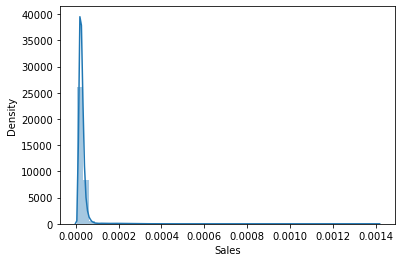

In [44]:
# Reciprocal Transformation
recip_sp = 1/train['Sales']
sns.distplot(recip_sp)

<AxesSubplot:xlabel='Sales', ylabel='Density'>

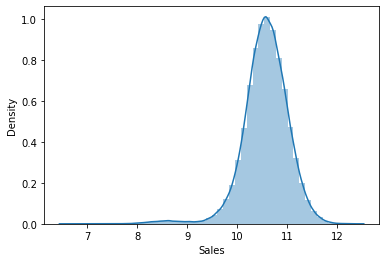

In [45]:
# Log Tranformation
log_sp = np.log(train['Sales'])
sns.distplot(log_sp)

It can be observed that square root transformation is ideal. Hence, square root transformation is applied to the 'Sales' variable. 

In [46]:
# Transforming the variable 'Avg_Account_Balance' with Square root
train['Sales'] = train['Sales']**(.5)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188321 entries, 0 to 188339
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Sales                188321 non-null  float64
 1   Weekend              188321 non-null  int64  
 2   Dateinbetween25and5  188321 non-null  int64  
 3   Holiday_weekend      188321 non-null  int64  
 4   Holiday_weekday      188321 non-null  int64  
 5   Store_Type_S2        188321 non-null  uint8  
 6   Store_Type_S3        188321 non-null  uint8  
 7   Store_Type_S4        188321 non-null  uint8  
 8   Location_Type_L2     188321 non-null  uint8  
 9   Location_Type_L3     188321 non-null  uint8  
 10  Location_Type_L4     188321 non-null  uint8  
 11  Location_Type_L5     188321 non-null  uint8  
 12  Region_Code_R2       188321 non-null  uint8  
 13  Region_Code_R3       188321 non-null  uint8  
 14  Region_Code_R4       188321 non-null  uint8  
 15  Discount_Yes     

### Correlation Analysis

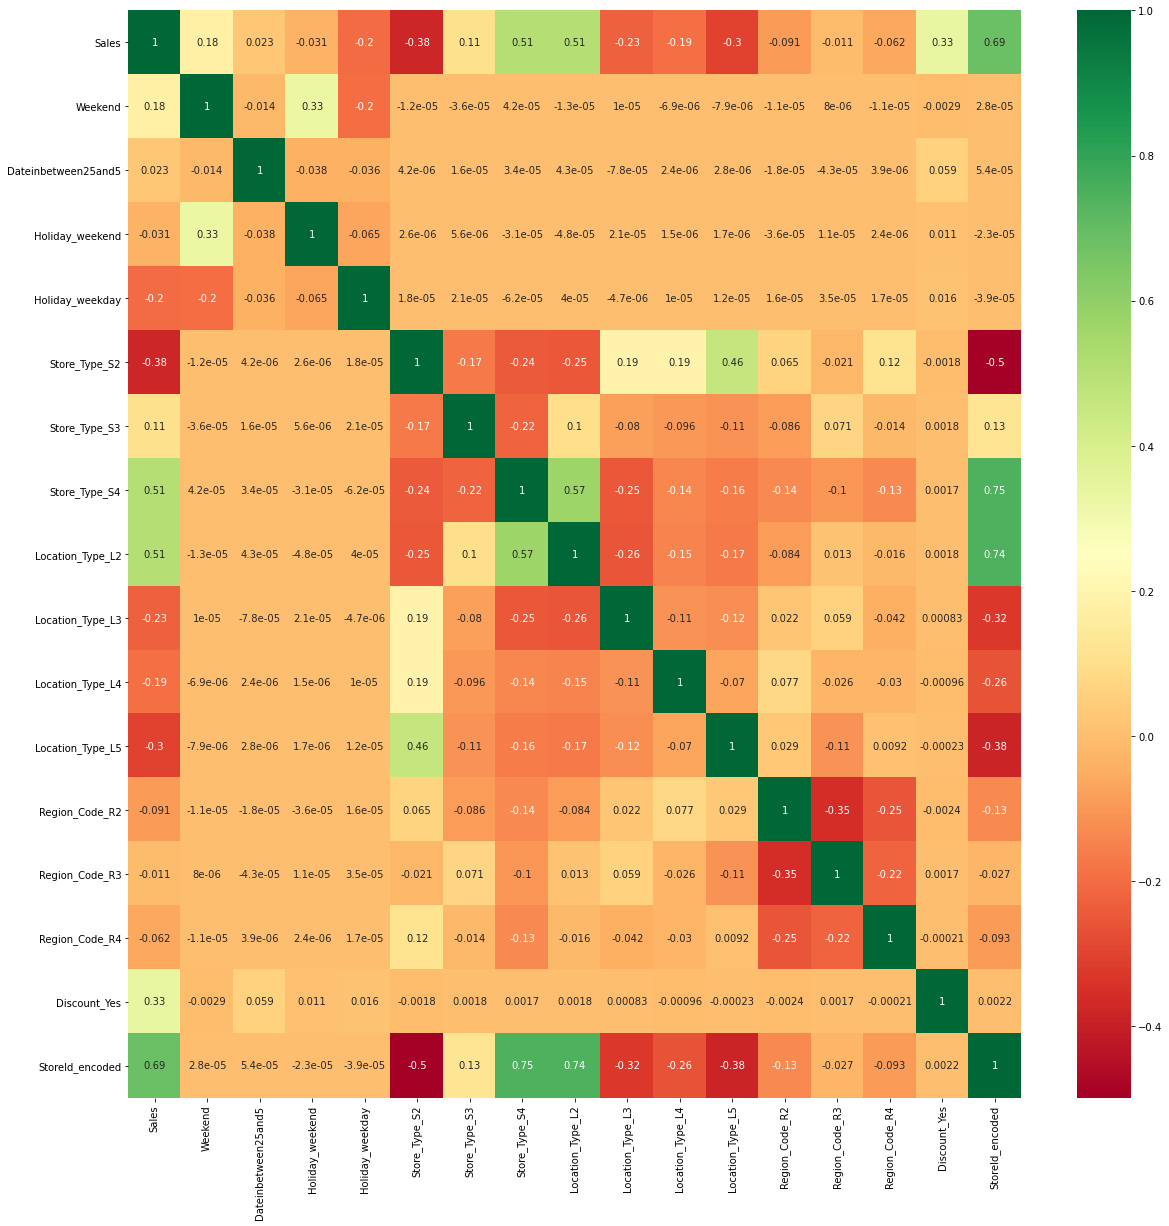

In [48]:
# Getting the correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Plotting the heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Splitting into X and y

In [49]:
X= train.drop(columns = ['Sales'], axis=1)
y= train['Sales']

## Building the Machine Learning Models and Cross Validation

We will be evaluating the models using Mean Squared Log Error (MSLE) evaluation metric. 

### 1. Linear Regression Model

In [52]:
linearreg_model = LinearRegression()
lr_scores = cross_val_score(linearreg_model, X, y, cv=5,scoring='neg_mean_squared_log_error')
msle_linearreg = lr_scores.mean()*(-1)
print(" Mean Squared Log Error for Linear Regression:", msle_linearreg)


 Mean Squared Log Error for Linear Regression: 0.022094648591958407


### 2. XGBoost Model

In [53]:
xgb_model = XGBRegressor(n_estimators = 100,learning_rate = 0.15)
xgb_scores = cross_val_score(xgb_model, X, y, cv=5,scoring='neg_mean_squared_log_error')
msle_xgboost = xgb_scores.mean()*(-1)
print(" Mean Squared Log Error for XGBoost:", msle_xgboost)

 Mean Squared Log Error for XGBoost: 0.021904233864006584


### 3. LightGBM Model

In [54]:
lgbm_model = LGBMRegressor(learning_rate = 0.15,max_depth = 6)
lgbm_scores = cross_val_score(lgbm_model, X, y, cv=5,scoring='neg_mean_squared_log_error')
msle_lightgbm = lgbm_scores.mean()*(-1)
print(" Mean Squared Log Error for LightGBM:", msle_lightgbm)

 Mean Squared Log Error for LightGBM: 0.022009363080028717


In [55]:
# Comparing performance of above three models - through RMSE
msle_linearreg = format(float(msle_linearreg))
msle_xgboost = format(float(msle_xgboost))
msle_lightgbm = format(float(msle_lightgbm))

model_errors = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost", "LightGBM"],
    "MSLE": [msle_linearreg, msle_xgboost, msle_lightgbm]
})

model_errors.sort_values(by = "MSLE")

,Model,MSLE
1,XGBoost,0.021904233864006584
2,LightGBM,0.022009363080028717
0,Linear Regression,0.022094648591958407


### The final model selected for prediction is XGBoost as it performs better than the other two models according to the MSLE scores. 

## Predicting the Sales Values for Test Dataset

In [56]:
xgb_model.fit(X, y)
pred_xgb = xgb_model.predict(test)

### Adding the predicted values to the submission file

In [57]:
submission = pd.read_csv('Submission.csv')
submission['Sales'] = pred_xgb**2 # Squaring the predicting values as back transform it. 
submission.to_csv('Submission.csv', index=False)